# Save Results of all Models for a given Data and Model Version

Loop over all Folds and Models and save the results in a dataframe.  
Calculate a threshold for outcome prediction on the validation data (based on geometric mean) and apply it to the test data.  
Add a normalized prediction uncertainty based on the standard deviation of the predictions of the different models.  


## Load Libraries and Modules

In [1]:
%matplotlib inline

import os
import h5py
import pandas as pd
import numpy as np
import pickle as pkl
import time

import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical
from statsmodels.stats.proportion import proportion_confint
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras

print("TF  Version",tf.__version__)

Using TensorFlow backend.


TF  Version 2.2.0


In [2]:
# check and set path before loading modules
print(os.getcwd())
DIR = "/tf/notebooks/schnemau/xAI_stroke_3d/"
if os.getcwd() != DIR:
    os.chdir(DIR)
    print(os.getcwd())

import functions_metrics as fm
import functions_model_definition as md
import functions_read_data as rdat
import Utils_maurice as utils

#ontram functions
from k_ontram_functions.ontram import ontram
from k_ontram_functions.ontram_loss import ontram_loss
from k_ontram_functions.ontram_metrics import ontram_acc, ontram_auc
from k_ontram_functions.ontram_predict import predict_ontram, get_parameters

/tf
/tf/notebooks/schnemau/xAI_stroke_3d


## Load Data and Results

In [3]:
version = "10Fold_CIBLSX" 
layer_connection = "globalAveragePooling" 
last_activation = "linear" 
# Define Model Version
model_version = 1

# should csv be saved?
save_file = True

DATA_OUTPUT_DIR = DIR + "data/"

In [4]:
# Setup the paths for the result assembly
DATA_DIR = DIR + "data/" 
WEIGHT_DIR = DIR + "weights/" + version + "/"
id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V0.csv", sep=",")
X = np.load(DATA_DIR + "prepocessed_dicom_3d.npy")
all_result_name = "all_tab_results_" + version + "_M" + str(model_version)
which_splits = list(range(0,10)) # 10 Fold
print(id_tab.shape)
print(X.shape)

(407, 14)
(407, 128, 128, 28)


In [5]:
print(WEIGHT_DIR)
print(all_result_name)

/tf/notebooks/schnemau/xAI_stroke_3d/weights/10Fold_CIBLSX/
all_tab_results_10Fold_CIBLSX_M1


In [6]:
(X_train, X_valid, X_test),(X_tab_train, X_tab_valid, X_tab_test), (y_train, y_valid, y_test) = rdat.split_data_tabular(id_tab, X, 1)

input_dim = (128, 128, 28, 1)
output_dim = 1
batch_size = 6
C = 2 

mbl = utils.img_model_linear_final(input_dim, output_dim)
mls = utils.mod_linear_shift(X_tab_train.shape[1])
model_3d = ontram(mbl, mls)             

model_3d.compile(optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
                                loss=ontram_loss(C, batch_size),
                                metrics=[ontram_acc(C, batch_size)])

In [7]:
model_nrs = list(range(5))

In [8]:
results_list = [] # test dataset results
valid_list = [] # validation datset results
betas = [] # validation datset results


for which_split in which_splits:
    (X_train, X_valid, X_test),(X_tab_train, X_tab_valid, X_tab_test), (y_train, y_valid, y_test) = rdat.split_data_tabular(id_tab, X, which_split)

    X_train = np.expand_dims(X_train, axis=-1)
    X_valid = np.expand_dims(X_valid, axis=-1)
    X_test = np.expand_dims(X_test, axis=-1)
    Y_train = to_categorical(y_train)
    Y_valid = to_categorical(y_valid)
    Y_test = to_categorical(y_test)
        
    test_data = tf.data.Dataset.from_tensor_slices((X_test, X_tab_test))
    test_labels = tf.data.Dataset.from_tensor_slices((Y_test))
    test_loader = tf.data.Dataset.zip((test_data, test_labels))
    test_dataset_pred = (test_loader.batch(len(X_test)))

    valid_data = tf.data.Dataset.from_tensor_slices((X_valid, X_tab_valid))
    valid_labels = tf.data.Dataset.from_tensor_slices((Y_valid))
    valid_loader = tf.data.Dataset.zip((valid_data, valid_labels))
    valid_dataset_pred = (valid_loader.batch(len(X_valid)))  
  
    results = id_tab[id_tab["fold" + str(which_split)] == "test"].copy()      
        
    results["test_split"] = which_split        
    
    validation_results = pd.DataFrame(
        {"test_split": which_split,
         "unfavorable": y_valid}
    )
       
    shift_params = []
    intercepts_test = []
    intercepts_val = []
    y_test_preds = []
    y_valid_preds = []
   
    for model_nr in model_nrs:        
        model_name = ("/tf/notebooks/schnemau/xAI_stroke_3d/weights/10Fold_CIBLSX/3d_cnn_binary_model_split" + "CIB_LSX" + str(which_split) + 
                          "_normalized_avg_layer_paper_model_" + last_activation + 
                          "_activation_" + str(model_version) + "_" + str(model_nr) + ".h5")        
        
        model_3d.load_weights(model_name)
        
        #test
        predic =  predict_ontram(model_3d, data = test_dataset_pred)['pdf'][:,1]
        y_test_preds.append(predic.squeeze())
        results["y_pred_model_" + str(model_nr)] = y_test_preds[-1]

        #valid
        predicc = predict_ontram(model_3d, data = valid_dataset_pred)['pdf'][:,1]
        y_valid_preds.append(predicc.squeeze())
        validation_results["y_pred_model_" + str(model_nr)] = y_valid_preds[-1]   

        #ensembling        
        shift_params.append(get_parameters(model_3d)['shift'][0][0][0])
        #test
        preds_test = model_3d.predict(test_dataset_pred)
        intercepts_test.append(preds_test[:, 0])
        #valid
        preds_val = model_3d.predict(valid_dataset_pred)
        intercepts_val.append(preds_val[:, 0])

    
    y_test_preds = np.array(y_test_preds)
    y_valid_preds = np.array(y_valid_preds)

    #ensembling
    average_intercepts_test = np.mean(np.array(intercepts_test), axis=0)
    average_intercepts_val = np.mean(np.array(intercepts_val), axis=0)
    average_betas = np.mean(np.array(shift_params), axis=0)
    linprod_test = np.dot(X_tab_test, average_betas)
    linprod_val = np.dot(X_tab_valid, average_betas)

    betas.append(average_betas)

    results["y_pred_trafo_avg"] = 1-utils.sigmoid(average_intercepts_test - linprod_test.flatten())
    validation_results["y_pred_trafo_avg"] = 1-utils.sigmoid(average_intercepts_val - linprod_val.flatten())

    results_list.append(results)
    valid_list.append(validation_results)


In [9]:
betas

[array([[ 0.26264578],
        [ 0.04154072],
        [ 0.2416564 ],
        [ 0.0325652 ],
        [-0.00382069],
        [-0.08800958],
        [-0.07106896],
        [ 0.15846333],
        [ 0.01538781],
        [-0.20562115],
        [ 0.20672235],
        [ 0.0177644 ],
        [ 0.13886525]], dtype=float32),
 array([[ 0.15576448],
        [ 0.13579282],
        [ 0.13165438],
        [ 0.14639926],
        [ 0.19094053],
        [-0.01914126],
        [ 0.07250601],
        [ 0.1544395 ],
        [ 0.25104037],
        [-0.11979334],
        [ 0.13355371],
        [ 0.18623906],
        [-0.03746182]], dtype=float32),
 array([[ 0.24955535],
        [-0.08668348],
        [ 0.32953563],
        [ 0.24934418],
        [ 0.13432977],
        [-0.28217667],
        [-0.13381214],
        [ 0.15262929],
        [-0.05062186],
        [ 0.0174404 ],
        [-0.07366488],
        [ 0.14326754],
        [ 0.28761384]], dtype=float32),
 array([[-0.00047289],
        [-0.08958789],
      

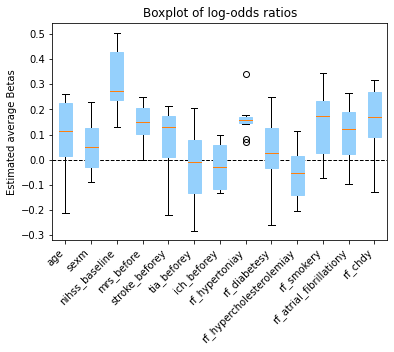

In [16]:
betas_reshaped = np.array(betas).reshape(10, 13)
# Set a color palette
palette = sns.color_palette("husl", n_colors=betas_reshaped.shape[0])

# Create a boxplot for each variable with light blue color
boxprops = dict(facecolor=sns.xkcd_rgb["light blue"], color=sns.xkcd_rgb["light blue"])
plt.boxplot(betas_reshaped, patch_artist=True, boxprops=boxprops)

# Add a horizontal line at 0
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Customize the plot (add labels, title, etc. as needed)
plt.xlabel('')
plt.ylabel('Estimated average Betas')
plt.title('Boxplot of log-odds ratios')

# Add x-axis tick labels with variable names
variable_names = ["age", "sexm", "nihss_baseline", "mrs_before",
                  "stroke_beforey", "tia_beforey", "ich_beforey", 
                  "rf_hypertoniay", "rf_diabetesy", "rf_hypercholesterolemiay", 
                  "rf_smokery", "rf_atrial_fibrillationy", "rf_chdy"]

plt.xticks(range(1, len(variable_names) + 1), variable_names, rotation=45, ha='right')

# Show the plot
plt.show()

## Calculate Threshold

Calculation of threshold for classification is done on validation data. Then applied to the test data.

 
---- Split 0 ----
 
Optimal Geometric Mean Threshold: 0.19537047358109438
Accuracy to beat: 0.8048780487804879
Accuracy: 0.8536585365853658
Spezifität:  0.9090909090909091
Sensitivität:  0.625


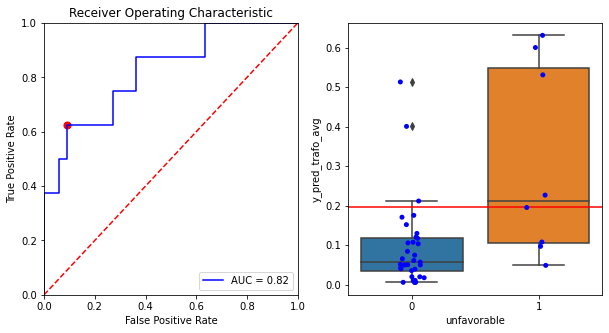

 
---- Split 1 ----
 
Optimal Geometric Mean Threshold: 0.3203169170839154
Accuracy to beat: 0.8048780487804879
Accuracy: 0.8536585365853658
Spezifität:  0.9090909090909091
Sensitivität:  0.625


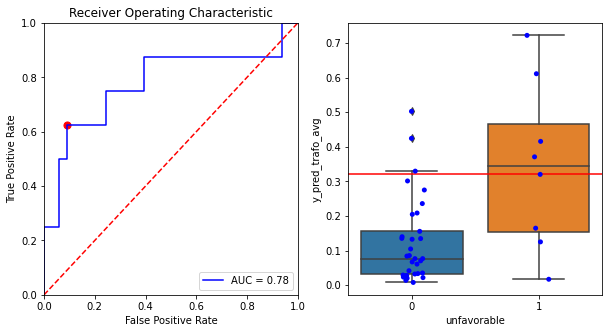

 
---- Split 2 ----
 
Optimal Geometric Mean Threshold: 0.2470049848819914
Accuracy to beat: 0.825
Accuracy: 0.9
Spezifität:  0.9393939393939394
Sensitivität:  0.7142857142857143


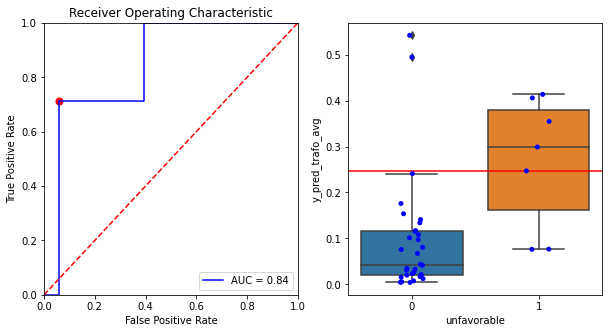

 
---- Split 3 ----
 
Optimal Geometric Mean Threshold: 0.1645376080579929
Accuracy to beat: 0.825
Accuracy: 0.8
Spezifität:  0.7878787878787878
Sensitivität:  0.8571428571428571


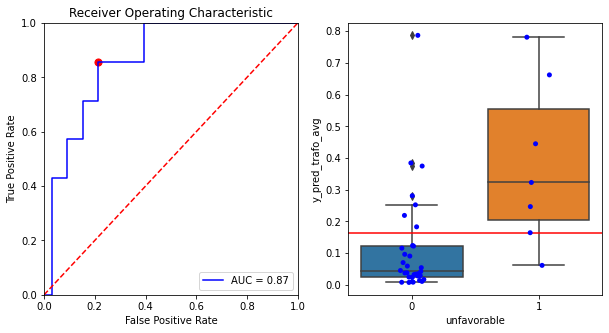

 
---- Split 4 ----
 
Optimal Geometric Mean Threshold: 0.22855854259314923
Accuracy to beat: 0.825
Accuracy: 0.875
Spezifität:  0.9393939393939394
Sensitivität:  0.5714285714285714


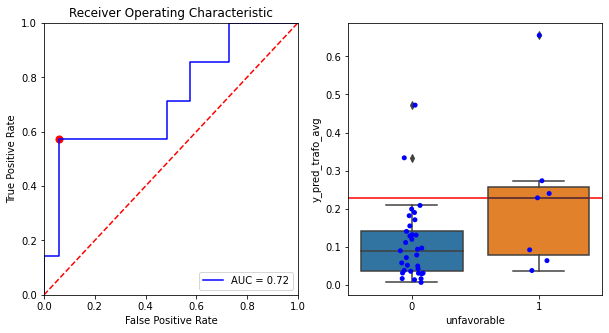

 
---- Split 5 ----
 
Optimal Geometric Mean Threshold: 0.42844788640772635
Accuracy to beat: 0.8292682926829268
Accuracy: 0.975609756097561
Spezifität:  1.0
Sensitivität:  0.8571428571428571


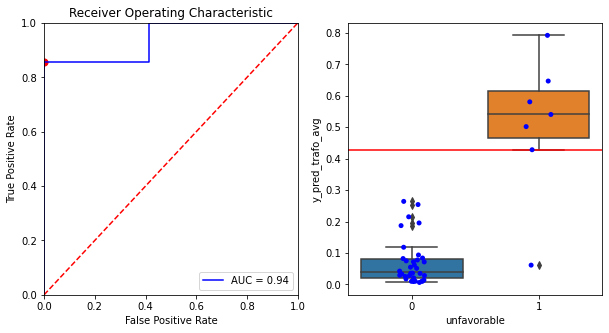

 
---- Split 6 ----
 
Optimal Geometric Mean Threshold: 0.0999759263322475
Accuracy to beat: 0.8292682926829268
Accuracy: 0.6829268292682927
Spezifität:  0.6176470588235294
Sensitivität:  1.0


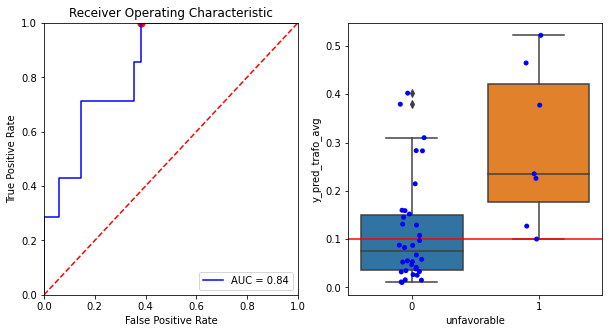

 
---- Split 7 ----
 
Optimal Geometric Mean Threshold: 0.08660446270792599
Accuracy to beat: 0.8048780487804879
Accuracy: 0.8048780487804879
Spezifität:  0.7575757575757576
Sensitivität:  1.0


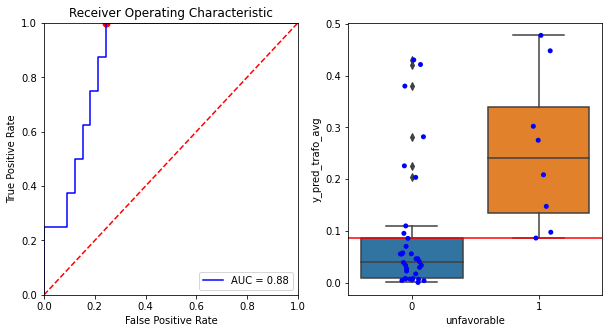

 
---- Split 8 ----
 
Optimal Geometric Mean Threshold: 0.14542659091044174
Accuracy to beat: 0.8048780487804879
Accuracy: 0.8048780487804879
Spezifität:  0.7878787878787878
Sensitivität:  0.875


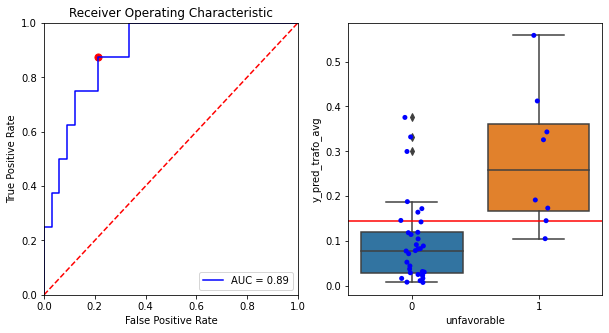

 
---- Split 9 ----
 
Optimal Geometric Mean Threshold: 0.21972848291901403
Accuracy to beat: 0.8048780487804879
Accuracy: 0.8048780487804879
Spezifität:  0.8181818181818181
Sensitivität:  0.75


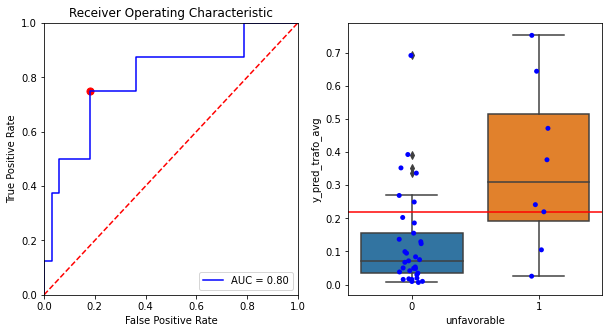

In [45]:
valid_thresholds = []

for i, validation_results in enumerate(valid_list):
    print(" ")
    print("---- Split " + str(which_splits[i]) + " ----")
    print(" ")
    
    y_org = validation_results["unfavorable"]
    y_pred = validation_results["y_pred_trafo_avg"]
    
    # calculate fpr, tpr and thresholds
    fpr, tpr, threshold = metrics.roc_curve(y_org, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    # calculate geometric mean of tpr and fpr to find best threshold
    gmean = np.sqrt(tpr * (1 - fpr))

    # Find the optimal threshold
    index = np.argmax(gmean)
    valid_thresholds.append(threshold[index])
    print("Optimal Geometric Mean Threshold: " + str(threshold[index]))
    
    # Calc Acc
    y_pred_label = (y_pred >= threshold[index]).squeeze()
    print("Accuracy to beat: " + str(1 - np.mean(y_org)))
    print("Accuracy: " + str(np.mean(y_pred_label == y_org)))
          
    print("Spezifität: ", 1-fpr[index])
    print("Sensitivität: ", tpr[index])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
    
    # method I: plt
    ax1.title.set_text('Receiver Operating Characteristic')
    ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    ax1.scatter(fpr[index], tpr[index], color = "red", s = 50)
    ax1.legend(loc = 'lower right')
    ax1.plot([0, 1], [0, 1],'r--')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate')
    
    sns.boxplot(x = "unfavorable",
        y = "y_pred_trafo_avg",
        data = validation_results,
        ax = ax2)
    sns.stripplot(x = "unfavorable",
        y = "y_pred_trafo_avg",
        color = 'blue',
        data = validation_results,
        ax = ax2)
    ax2.axhline(y = threshold[index], color = "red")
    
    plt.show()

In [47]:
np.round(valid_thresholds,3)

array([0.195, 0.32 , 0.247, 0.165, 0.229, 0.428, 0.1  , 0.087, 0.145,
       0.22 ])

### Apply Threshold to Testdata

 
---- Split 0 ----
 
Accuracy to beat: 0.8292682926829268
Accuracy: 0.926829268292683
Spezifität:  0.9411764705882353
Sensitivität:  0.8571428571428571


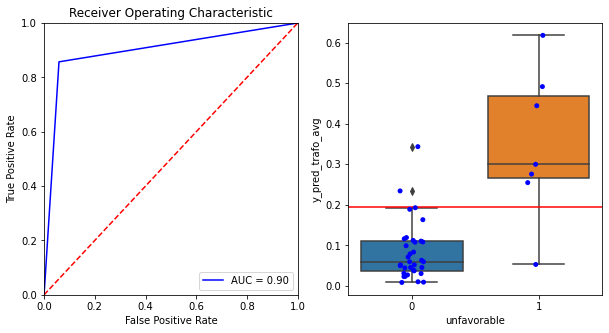

 
---- Split 1 ----
 
Accuracy to beat: 0.8292682926829268
Accuracy: 0.7804878048780488
Spezifität:  0.8235294117647058
Sensitivität:  0.5714285714285714


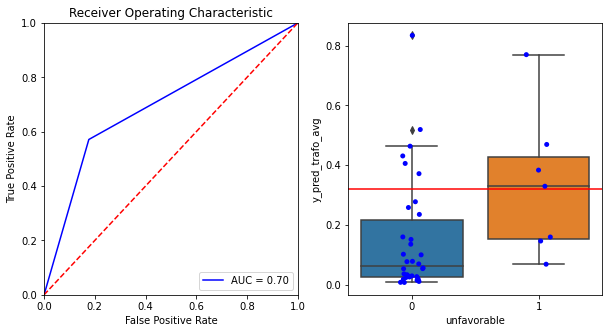

 
---- Split 2 ----
 
Accuracy to beat: 0.8048780487804879
Accuracy: 0.7804878048780488
Spezifität:  0.9090909090909091
Sensitivität:  0.25


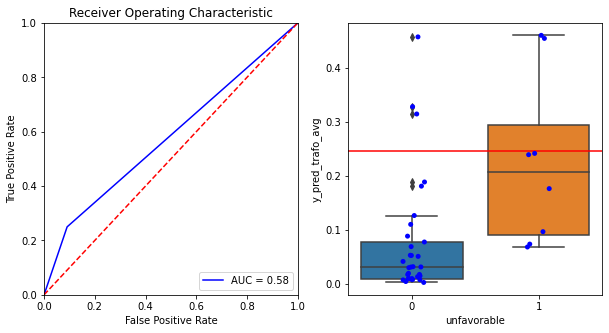

 
---- Split 3 ----
 
Accuracy to beat: 0.8048780487804879
Accuracy: 0.6829268292682927
Spezifität:  0.696969696969697
Sensitivität:  0.625


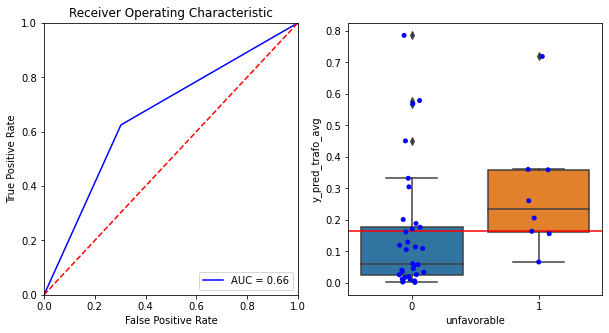

 
---- Split 4 ----
 
Accuracy to beat: 0.8048780487804879
Accuracy: 0.8292682926829268
Spezifität:  0.8787878787878788
Sensitivität:  0.625


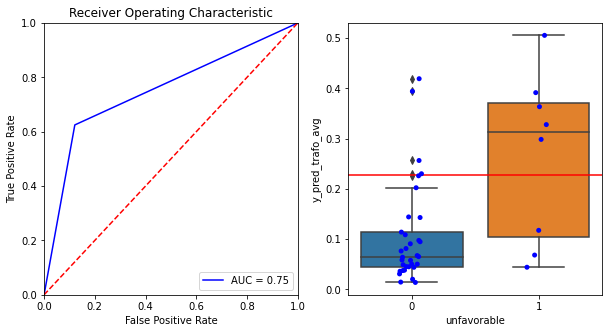

 
---- Split 5 ----
 
Accuracy to beat: 0.8048780487804879
Accuracy: 0.8780487804878049
Spezifität:  1.0
Sensitivität:  0.375


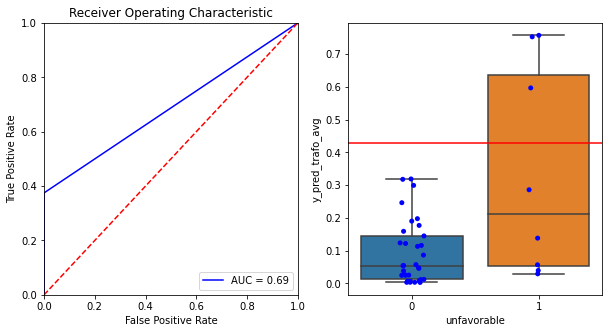

 
---- Split 6 ----
 
Accuracy to beat: 0.8048780487804879
Accuracy: 0.6829268292682927
Spezifität:  0.6363636363636364
Sensitivität:  0.875


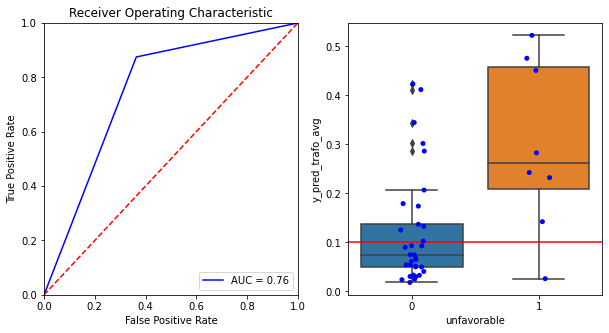

 
---- Split 7 ----
 
Accuracy to beat: 0.825
Accuracy: 0.675
Spezifität:  0.6363636363636364
Sensitivität:  0.8571428571428571


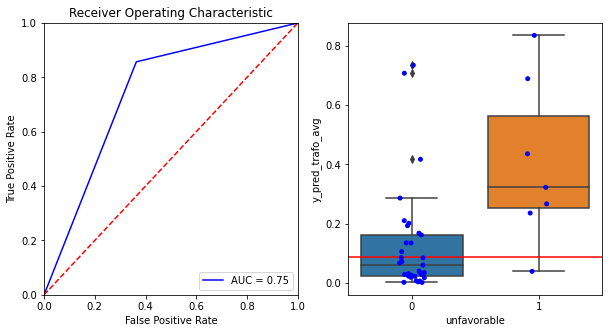

 
---- Split 8 ----
 
Accuracy to beat: 0.825
Accuracy: 0.85
Spezifität:  0.8787878787878788
Sensitivität:  0.7142857142857143


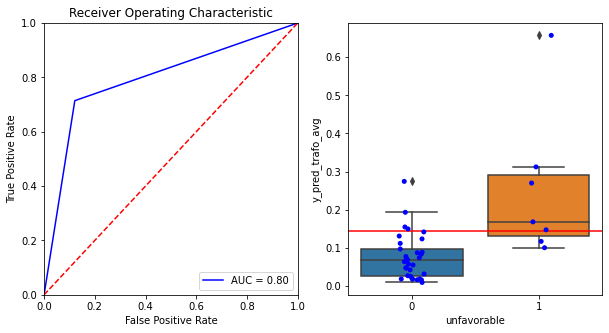

 
---- Split 9 ----
 
Accuracy to beat: 0.825
Accuracy: 0.75
Spezifität:  0.8181818181818181
Sensitivität:  0.42857142857142855


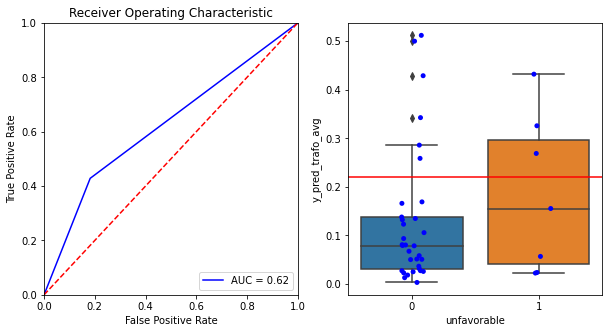

In [48]:
for i, results in enumerate(results_list):
    print(" ")
    print("---- Split " + str(which_splits[i]) + " ----")
    print(" ")

    results["threshold"] = valid_thresholds[i]
    results["y_pred_class"] = (results["y_pred_trafo_avg"] >= results["threshold"]).astype(int)
    
    y_org = results["unfavorable"]
    y_pred = results["y_pred_class"]
    
    # calculate fpr, tpr and thresholds
    fpr, tpr, threshold = metrics.roc_curve(y_org, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
      
    # Calc Acc
    print("Accuracy to beat: " + str(1 - np.mean(y_org)))
    print("Accuracy: " + str(np.mean(y_pred == y_org)))
          
    print("Spezifität: ", 1-fpr[1])
    print("Sensitivität: ", tpr[1])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
    
    # method I: plt
    ax1.title.set_text('Receiver Operating Characteristic')
    ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    ax1.legend(loc = 'lower right')
    ax1.plot([0, 1], [0, 1],'r--')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate')
    
    sns.boxplot(x = "unfavorable",
        y = "y_pred_trafo_avg",
        data = results,
        ax = ax2)
    sns.stripplot(x = "unfavorable",
        y = "y_pred_trafo_avg",
        color = 'blue',
        data = results,
        ax = ax2)
    ax2.axhline(y = valid_thresholds[i], color = "red")
    
    plt.show()

#### Concat all Pandas and Analyze

In [51]:
all_results = pd.concat(results_list)
all_results.shape
all_results

,p_idx,p_id,mrs,unfavorable,fold0,fold1,fold2,fold3,fold4,fold5,...,fold9,test_split,y_pred_model_0,y_pred_model_1,y_pred_model_2,y_pred_model_3,y_pred_model_4,y_pred_trafo_avg,threshold,y_pred_class
13,14,21,1.0,0,test,train,train,train,train,val,...,train,0,0.021409,0.008706,0.011752,0.004347,0.010668,0.010045,0.195370,0
26,27,36,0.0,0,test,train,train,train,train,val,...,train,0,0.078482,0.066415,0.218940,0.026023,0.091565,0.078780,0.195370,0
27,28,38,2.0,0,test,train,train,train,train,val,...,train,0,0.031955,0.046325,0.092207,0.052394,0.227226,0.071203,0.195370,0
33,34,44,1.0,0,test,train,train,train,train,val,...,train,0,0.170456,0.250173,0.151111,0.181767,0.202023,0.188954,0.195370,0
34,35,46,0.0,0,test,train,train,train,train,val,...,train,0,0.008533,0.018001,0.007016,0.006057,0.006401,0.008405,0.195370,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,345,486,0.0,0,train,train,train,train,val,train,...,test,9,0.138624,0.073613,0.284167,0.183057,0.216218,0.166124,0.219728,0
369,370,514,3.0,1,train,train,train,train,val,train,...,test,9,0.237644,0.065619,0.014339,0.122743,0.017489,0.056816,0.219728,0
393,394,541,0.0,0,train,train,train,train,val,train,...,test,9,0.048625,0.023103,0.035995,0.025119,0.011267,0.025886,0.219728,0
396,397,546,1.0,0,train,train,train,train,val,train,...,test,9,0.107886,0.034730,0.009225,0.018005,0.023540,0.027449,0.219728,0


In [18]:
y_org = all_results["unfavorable"]
y_pred_prob = all_results["y_pred_trafo_avg"]

metrics.log_loss(y_org, y_pred_prob)

0.3988579575786573

Accuracy to beat: 0.8157248157248157
Accuracy: 0.7837837837837838
Spezifität:  0.822289156626506
Sensitivität:  0.6133333333333333


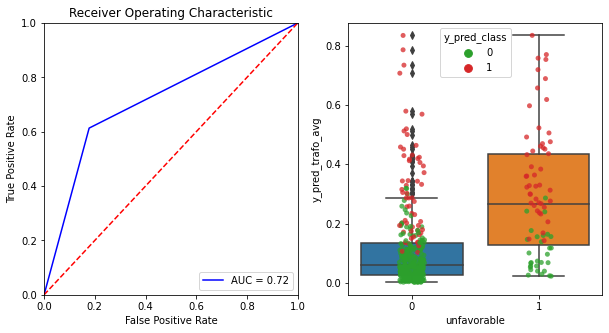

In [52]:
y_org = all_results["unfavorable"]
y_pred = all_results["y_pred_class"]

# calculate fpr, tpr and thresholds
fpr, tpr, threshold = metrics.roc_curve(y_org, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# Calc Acc
y_pred_label = all_results["y_pred_class"]
print("Accuracy to beat: " + str(1 - np.mean(y_org)))
print("Accuracy: " + str(np.mean(y_pred_label == y_org)))

print("Spezifität: ", 1-fpr[1])
print("Sensitivität: ", tpr[1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

# method I: plt
ax1.title.set_text('Receiver Operating Characteristic')
ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax1.legend(loc = 'lower right')
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')

sns.boxplot(x = "unfavorable",
    y = "y_pred_trafo_avg",
    data = all_results,
    ax = ax2)
sns.stripplot(x = "unfavorable",
    y = "y_pred_trafo_avg",
    hue = 'y_pred_class',
    palette=["C2", "C3", "k"],
    data = all_results,
    alpha = 0.75,
    ax = ax2)
    

In [56]:
np.round(0.3988579575786573,3)

0.399

## Calculate Model Uncertainty

Use the standard deviation of the predictions as a measure of uncertainty. Then use min max normalization to scale the uncertainty between 0 and 1.  
Compare the uncertainty with the predictions

In [15]:
all_results["y_pred_std"] = all_results[["y_pred_model_" + str(i) for i in range(5)]].std(axis = 1)
all_results["y_pred_unc"] = (all_results["y_pred_std"] - all_results.y_pred_std.min()) / (
    all_results.y_pred_std.max() - all_results.y_pred_std.min())

[Text(0, 0.5, 'prediction uncertainty'), Text(0.5, 0, 'true class')]

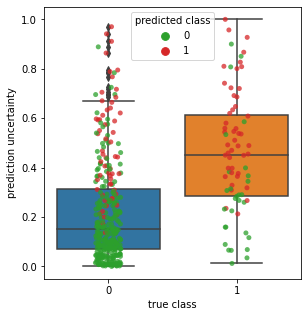

In [16]:
# Plot uncertainty
plt.figure(figsize = (4.6,5))
sns.boxplot(x = "unfavorable",
    y = "y_pred_unc",
    data = all_results)
g = sns.stripplot(x = "unfavorable",
    y = "y_pred_unc",
    hue = 'y_pred_class',
    alpha = 0.75,
    palette=["C2", "C3"],
    data = all_results)
plt.legend(title='predicted class', loc='upper center')
g.set(xlabel='true class', ylabel='prediction uncertainty')

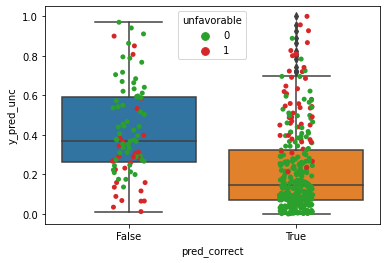

In [17]:
all_results["pred_correct"] = all_results["y_pred_class"] == all_results["unfavorable"] 

sns.boxplot(x = "pred_correct",
    y = "y_pred_unc",
    data = all_results)
sns.stripplot(x = "pred_correct",
    y = "y_pred_unc",
    hue = 'unfavorable',
    palette=["C2", "C3"],
    data = all_results)

### Save results

Delete threshold 1 because mulitple different thresholds does not make sense.

In [18]:
save_file = True

In [19]:
if save_file:
    all_results.to_csv(DATA_OUTPUT_DIR + all_result_name + "_dyn_threshold" + ".csv",  index=False) # rename output file!!!!

# Graveyard

In [ ]:
'''model_name = ("/tf/notebooks/schnemau/xAI_stroke_3d/weights/10Fold_CIBLSX/3d_cnn_binary_model_split" + "CIB_LSX" + str(1) + 
                    "_normalized_avg_layer_paper_model_" + last_activation + 
                    "_activation_" + str(1) + "_" + str(1) + ".h5")        

model_3d.load_weights(model_name)        

test_data = tf.data.Dataset.from_tensor_slices((X_test, X_tab_test))
test_labels = tf.data.Dataset.from_tensor_slices((to_categorical(y_test)))
test_loader = tf.data.Dataset.zip((test_data, test_labels))
test_dataset_pred = (test_loader.batch(len(X_test)))
prediccc =  predict_ontram(model_3d, data = test_dataset_pred)
preds = model_3d.predict(test_dataset_pred)
preds[:, 0]
'''